# Codigos Tarea 11 Inferencia Estadística. 

Aquí se incluye el código fuente los problemas computacionales de esta tarea los cuales son Problema 6 Capítulo 13 y Problema 11 Capítulo 13 de Wasserman: All of Statistics. 

## Problema 6

### a)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# Carga de la base de datos
data = pd.read_csv('carmilage.csv')

In [ ]:
def get_regression(X, Y):
    X = X.copy()
    
    # Agrega columna de 1's 
    X.insert(0, 'const', 1)
    
    # LSE
    beta_hat = (np.linalg.inv(X.T @ X) @ X.T @ Y).to_numpy()

    # Prediccion
    Y_pred = X @ beta_hat

    # Errores
    epsilon_hat = Y_pred - Y

    # SSE
    training_error = epsilon_hat.T @ epsilon_hat
    
    # Varianza (estimador insesgado)
    sigma2_hat = (training_error / (Y.shape[0] - X.shape[1]))

    # Error estándar de los coeficientes
    se_beta_hat = np.sqrt(sigma2_hat * np.diag(np.linalg.inv(X.T @ X))).T

    # Estadístico para la prueba 1
    t_values = beta_hat.reshape(-1) / se_beta_hat

    # p valores
    p_values = 2 * (1 - t.cdf(np.abs(t_values), X.shape[0] - 1))
    
    return pd.DataFrame({
        'coef': beta_hat.reshape(-1),
        'std err': se_beta_hat.reshape(-1),
        't': t_values.reshape(-1),
        'P > |t|': p_values.reshape(-1) 
        }, index=X.columns)

In [ ]:
Y = data['MPG']
X = data[['HP']]
get_regression(X, Y)

,coef,std err,t,P > |t|
const,50.066078,1.569487,31.899650,0.0
HP,-0.139023,0.012069,-11.519295,0.0


Aquí usamos la librería `statsmodels`

In [ ]:
results = sm.OLS(Y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     132.7
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.15e-18
Time:                        02:39:10   Log-Likelihood:                -264.61
No. Observations:                  82   AIC:                             533.2
Df Residuals:                      80   BIC:                             538.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0661      1.569     31.900      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


A continuación mostramos las gráficas utilizando la librería.


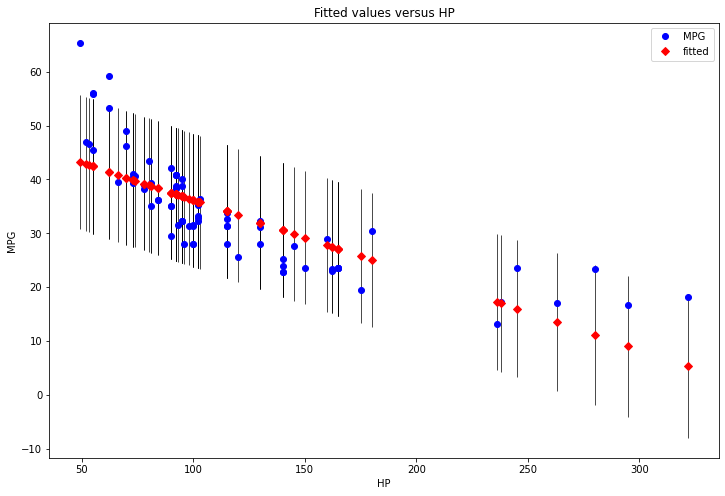

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results, 1, ax=ax)
plt.show()

### b)

Repeteimos el mismo procedimiento solo que esta vez la variable respuesta será `log(MPG)`

In [ ]:
Y = np.log(data['MPG']).rename('log MPG')
X = data[['HP']]
get_regression(X, Y)

,coef,std err,t,P > |t|
const,4.013229,0.040124,100.021194,0.0
HP,-0.004589,0.000309,-14.873129,0.0


In [ ]:
results = sm.OLS(Y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                log MPG   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     221.2
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           9.62e-25
Time:                        02:39:11   Log-Likelihood:                 36.047
No. Observations:                  82   AIC:                            -68.09
Df Residuals:                      80   BIC:                            -63.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0132      0.040    100.021      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


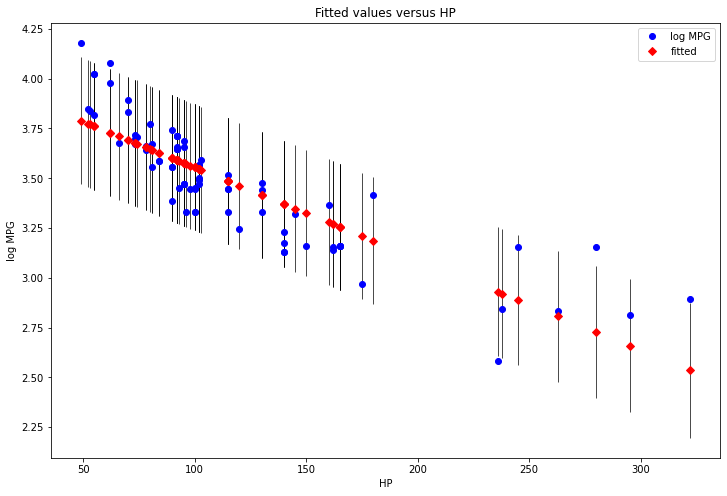

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results, 1, ax=ax)
plt.show()

## Problema 11

El siguiente código implementa *backward stepwise logistic regression* en la base de datos de CORIS. 

In [ ]:
data=pd.read_csv('coris.csv')
data=data[set(data.columns)-set({'row.names'})]
data = pd.get_dummies(data, columns=['famhist'], drop_first=True)
data.head()

,tobacco,typea,age,ldl,sbp,obesity,chd,alcohol,adiposity,famhist_Present
0,12.00,49,52,5.73,160,25.30,1,97.20,23.11,1
1,0.01,55,63,4.41,144,28.87,1,2.06,28.61,0
2,0.08,52,46,3.48,118,29.14,0,3.81,32.28,1
3,7.50,51,58,6.41,170,31.99,1,24.26,38.03,1
4,13.60,60,49,3.50,134,25.99,1,57.34,27.78,1


La variable indicadora de enfermedad coronaria es `chd`.

In [ ]:
# Usamos statsmodels
Y=data[['chd']]
X=data[set(data.columns)-set({'chd'})]
col_names=X.columns.to_list()
X = sm.add_constant(X)
log_reg = sm.Logit(Y, X).fit()

# Hacemos el backward stepwise
current_aic=log_reg.aic
# Modelo total
flag=1
while flag==1:
    aic={}
    for col in col_names:
        log_reg=sm.Logit(Y,X[set(X.columns)-set({col})]).fit()
        aic[col]=log_reg.aic
    tmp=min(aic, key=aic.get)
    if aic[tmp]<current_aic:
        current_aic=aic[tmp]
        col_names.remove(tmp)
        X=X[set(X.columns)-set({tmp})]
    else:
        flag=0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.510974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511412
  

El conjunto de variables seleccionadas con este método es

In [ ]:
col_names

['tobacco', 'typea', 'famhist_Present', 'age', 'ldl']